In [1]:
import os

import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
MODELS = ('CNN_ED_TCN_25', 'CNN_biLSTM', 'CNN_Dilated_TCN_25',)
model_names = ('encoder-decoder\nTCN', 'CNN-biLSTM', 'dilated\nTCN')
model_colors = ('green', 'violet', 'orange')
model_cmaps = ('Greens', 'Purples', 'Oranges')

#### bird 2

In [3]:
root_dir = '/media/art/HD-LCU3/compare-syl-seg/'
bird_results_dir_map = {
    'bird 1': 'results_181124_112900_for_summary/summary_181124_151859',
    'bird 2': 'results_181124_184505/summary_181125_133218',
    'bird 3': 'results_181124_184035/summary_181125_133330',
    'bird 4': 'results_181124_213822/summary_181125_133007'
    }

bird_results_dir_map = {key: os.path.join(root_dir, val) 
                        for key, val in bird_results_dir_map.items()}

In [4]:
err_by_model = {}
for bird, results_dir in bird_results_dir_map.items():
    err_by_model[bird] = joblib.load(os.path.join(results_dir, 'y_preds_and_err_for_train_and_test'))

In [5]:
bird_1_time_dur_inds = [0,2,3,5]
err_by_bird = {}
for bird, preds_and_err_dict in err_by_model.items():
    model_d_tmp = {}
    for key, val in preds_and_err_dict.items():
        if key in MODELS:
            d_tmp = {}
            for model_key, model_val in val.items():
                if model_key in ['train_err_arr', 'test_err_arr', 
                                 'train_syl_err_arr', 'test_syl_err_arr',
                                 'train_predict_time', 'test_predict_time']:
                    if bird == 'bird 1':
                        d_tmp[model_key] = model_val[bird_1_time_dur_inds, :]
                    else:
                        d_tmp[model_key] = model_val
            model_d_tmp[key] = d_tmp
    err_by_bird[bird] = model_d_tmp

In [6]:
times_by_bird = {}
for bird, preds_and_err_dict in err_by_model.items():
    model_d_tmp = {}
    for key, val in preds_and_err_dict.items():
        if key in MODELS:
            d_tmp = {}
            for model_key, model_val in val.items():
                if model_key in ['train_predict_time', 'test_predict_time']:
                    d_tmp[model_key] = model_val
            model_d_tmp[key] = d_tmp
    times_by_bird[bird] = model_d_tmp

#### framewise test error

In [65]:
def plot_err_by_model(err_by_bird, model, model_name, model_color, model_cmap,
                      train_durs = (5,15,30,120)):
    """plot error for a specific model,
    showing each individual bird + mean across birds
    
    Parameters
    ----------
    err_by_bird : dict
        where keys are bird names, and values are dicts mapping model names to error arrays
    model: str
        name of model type to plot
    """
    num_birds = len(err_by_bird)
    # map number of birds to range [0, 1], but avoiding extreme values we can't see
    color_vals_for_birds = np.linspace(0.45,1,num_birds)
    cmap = plt.get_cmap(model_cmap)
    colors_for_birds = cmap(color_vals_for_birds)
    
    plt.style.use('ggplot')

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    mn_frame_err_across_birds = []
    mn_syl_err_across_birds = []
    
    for color_ind, (bird, model_dict) in enumerate(err_by_bird.items()):
        frame_err = err_by_bird[bird][model]['test_err_arr']
        mean_frame_err = np.mean(frame_err, axis=1)
        ax[0].plot(train_durs, mean_frame_err, alpha=0.75, 
                   linestyle='--', color=colors_for_birds[color_ind], label=bird)
        mn_frame_err_across_birds.append(mean_frame_err)
        
        syl_err = err_by_bird[bird][model]['test_syl_err_arr']
        mean_syl_err = np.mean(syl_err, axis=1)
        ax[1].plot(train_durs, mean_syl_err, alpha=0.65,
                   linestyle='--', color=colors_for_birds[color_ind], label=bird)
        mn_syl_err_across_birds.append(mean_syl_err)

    mn_frame_err_across_birds = np.stack(mn_frame_err_across_birds)
    mn_syl_err_across_birds = np.stack(mn_syl_err_across_birds)
    ax[0].plot(train_durs, np.mean(mn_frame_err_across_birds, axis=0), 
               color=model_color, linewidth=3, label=model_name)
    ax[1].plot(train_durs, np.mean(mn_syl_err_across_birds, axis=0), 
               color=model_color, linewidth=3, label=model_name)

    ax[0].set_xticks(train_durs)
    ax[0].set_title('framewise error v. training set size')
    ax[0].set_xlabel('training set size (s)')
    ax[0].set_ylabel('framewise error')
    ax[0].legend()
    ax[0].set_ylim([0, 0.22])
    
    ax[1].set_xticks(train_durs)
    ax[1].set_title('syllable error rate v. training set size')
    ax[1].set_xlabel('training set size (s)')
    ax[1].set_ylabel('syllable error rate')
    ax[1].legend()
    ax[1].set_ylim([0, 2.2])
    plt.savefig('err_by_model_{}.png'.format(model))

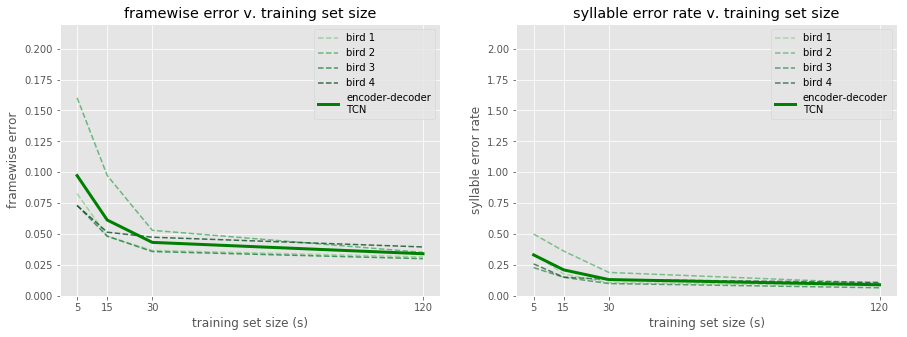

In [66]:
plot_err_by_model(err_by_bird,MODELS[0], model_names[0], model_colors[0], model_cmaps[0])

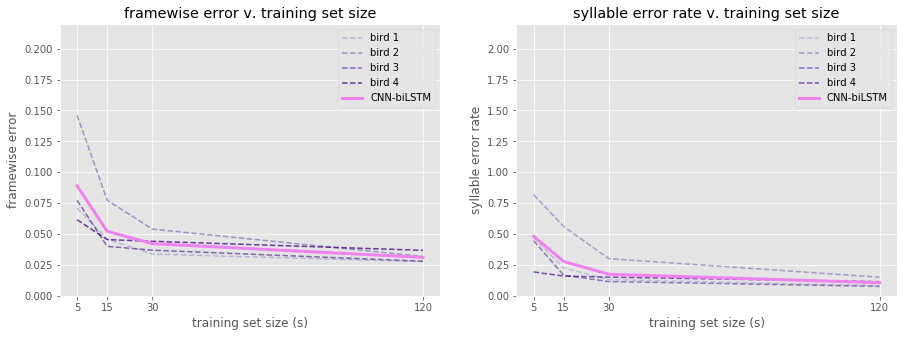

In [69]:
plot_err_by_model(err_by_bird,MODELS[1], model_names[1], model_colors[1], model_cmaps[1])

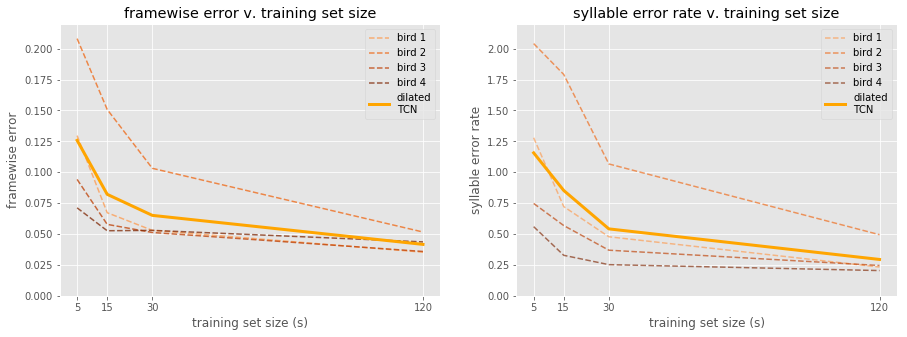

In [70]:
plot_err_by_model(err_by_bird,MODELS[2], model_names[2], model_colors[2], model_cmaps[2])

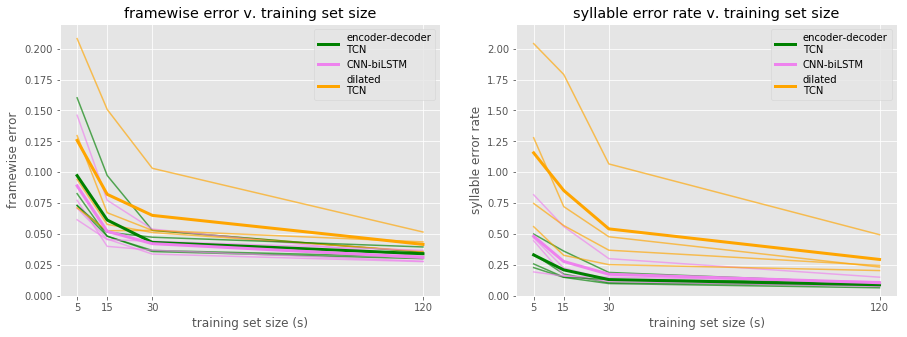

In [71]:
plt.style.use('ggplot')

train_durs = [5,15,30,120]

fig, ax = plt.subplots(1, 2)
ax = ax.ravel()
fig.set_size_inches(15, 5)


frame_err_across_birds = {}
syl_err_across_birds = {}
for model in MODELS:
    frame_err_across_birds[model] = []
    syl_err_across_birds[model] = []

for bird in ('bird 1', 'bird 2', 'bird 3', 'bird 4'):
    for model, model_name, model_color in zip(MODELS, model_names, model_colors):
        frame_err = err_by_bird[bird][model]['test_err_arr']
        frame_err_across_birds[model].append(frame_err)
        syl_err = err_by_bird[bird][model]['test_syl_err_arr']
        syl_err_across_birds[model].append(syl_err)
        
        ax[0].plot(train_durs, np.mean(frame_err, axis=1), alpha=0.65, color=model_color)
        ax[1].plot(train_durs, np.mean(syl_err, axis=1), alpha=0.65, color=model_color)

for model, model_name, model_color in zip(MODELS, model_names, model_colors):
    frame_err_across_birds[model] = np.concatenate(frame_err_across_birds[model], axis=1)
    ax[0].plot(train_durs, np.mean(frame_err_across_birds[model], axis=1), 
               color=model_color, linewidth=3, label=model_name)
    syl_err_across_birds[model] = np.concatenate(syl_err_across_birds[model], axis=1)
    ax[1].plot(train_durs, np.mean(syl_err_across_birds[model], axis=1),
               color=model_color, linewidth=3, label=model_name)

ax[0].set_xticks(train_durs)
ax[0].set_title('framewise error v. training set size')
ax[0].set_xlabel('training set size (s)')
ax[0].set_ylabel('framewise error')
ax[0].legend()
ax[0].set_ylim([0, 0.22])

ax[1].set_xticks(train_durs)
ax[1].set_title('syllable error rate v. training set size')
ax[1].set_xlabel('training set size (s)')
ax[1].set_ylabel('syllable error rate')
ax[1].legend()
ax[1].set_ylim([0, 2.2])
plt.savefig('err_all_models.png')

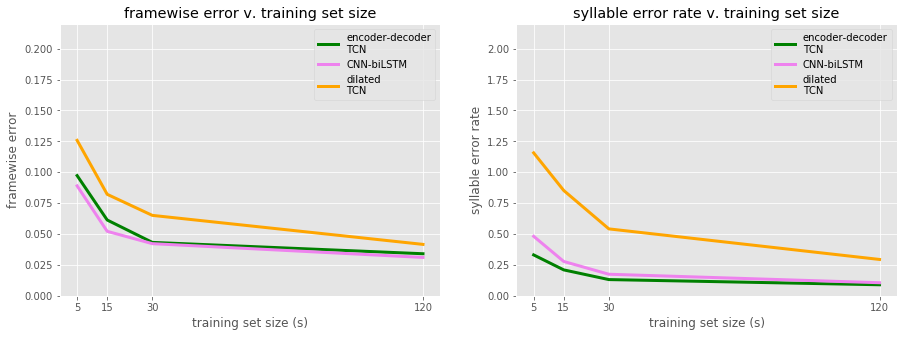

In [72]:
plt.style.use('ggplot')

train_durs = [5,15,30,120]

fig, ax = plt.subplots(1, 2)
ax = ax.ravel()
fig.set_size_inches(15, 5)


for model, model_name, model_color in zip(MODELS, model_names, model_colors):        
    ax[0].plot(train_durs, np.mean(frame_err_across_birds[model], axis=1), 
               color=model_color, linewidth=3, label=model_name)
    ax[1].plot(train_durs, np.mean(syl_err_across_birds[model], axis=1),
               color=model_color, linewidth=3, label=model_name)

ax[0].set_xticks(train_durs)
ax[0].set_title('framewise error v. training set size')
ax[0].set_xlabel('training set size (s)')
ax[0].set_ylabel('framewise error')
ax[0].legend()
ax[0].set_ylim([0, 0.22])

ax[1].set_xticks(train_durs)
ax[1].set_title('syllable error rate v. training set size')
ax[1].set_xlabel('training set size (s)')
ax[1].set_ylabel('syllable error rate')
ax[1].legend()
ax[1].set_ylim([0, 2.2])
plt.savefig('err_all_models.png')

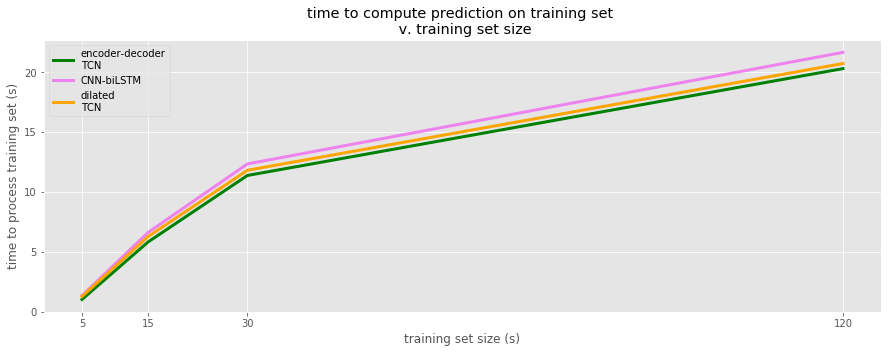

In [126]:
bird_1_time_dur_inds = [0,2,3,5]

train_predict_time_across_birds = {}
for model in MODELS:
    train_predict_time_across_birds[model] = []

for bird, times_dict in times_by_bird.items():
    for model in MODELS:
        if bird == 'bird 1':
            train_predict_time = times_dict[model]['train_predict_time'][bird_1_time_dur_inds, :]
        else:
            train_predict_time = times_dict[model]['train_predict_time']
        train_predict_time = np.mean(train_predict_time, axis=1)
        train_predict_time_across_birds[model].append(train_predict_time)

train_predict_time_across_birds = {model: np.mean(np.stack(times_list), axis=0)
                             for model, times_list in train_predict_time_across_birds.items()}

plt.style.use('ggplot')

train_durs = [5,15,30,120]

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

for model, model_name, model_color in zip(MODELS, model_names, model_colors):
    ax.plot(train_durs, train_predict_time_across_birds[model], 
            color=model_color, linewidth=3, label=model_name)
ax.legend()
ax.set_xticks(train_durs)
ax.set_title('time to compute prediction on training set \n v. training set size')
ax.set_xlabel('training set size (s)')
ax.set_ylabel('time to process training set (s)');
plt.savefig('predict_time_train.png')

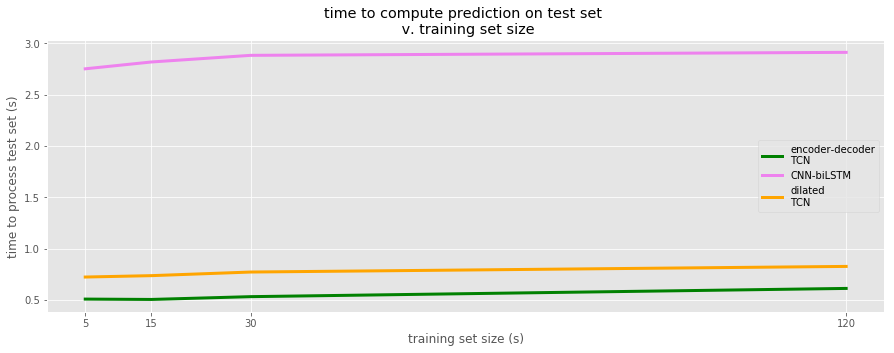

In [125]:
bird_1_time_dur_inds = [0,2,3,5]

test_predict_time_across_birds = {}
for model in MODELS:
    test_predict_time_across_birds[model] = []

for bird, times_dict in times_by_bird.items():
    for model in MODELS:
        if bird == 'bird 1':
            test_predict_time = times_dict[model]['test_predict_time'][bird_1_time_dur_inds, :]
        else:
            test_predict_time = times_dict[model]['test_predict_time']
        test_predict_time = np.mean(test_predict_time, axis=1)
        test_predict_time_across_birds[model].append(test_predict_time)

test_predict_time_across_birds = {model: np.mean(np.stack(times_list), axis=0)
                             for model, times_list in test_predict_time_across_birds.items()}

plt.style.use('ggplot')

train_durs = [5,15,30,120]

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)

for model, model_name, model_color in zip(MODELS, model_names, model_colors):
    ax.plot(train_durs, test_predict_time_across_birds[model], 
            color=model_color, linewidth=3, label=model_name)
ax.legend()
ax.set_xticks(train_durs)
ax.set_title('time to compute prediction on test set \n v. training set size')
ax.set_xlabel('training set size (s)')
ax.set_ylabel('time to process test set (s)');